In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


## **Download the Dataset**

In [3]:
#Import Libraries 
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import keras
from keras import backend as K
from keras import layers
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import pandas as pd
import cv2
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from numpy.random import seed
seed(1)

In [4]:
# Read the HAM10000 metadata 
df = pd.read_csv("C:/Users/hp/Desktop/vision_project/HAM10000_metadata.csv")

In [5]:
#Read the first 10 information in the dataset 
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [6]:
# Get the total number of rows and colums in dataset 
df.shape

(10015, 7)

### **Feature Engineering**

In [7]:
#Define the lesion names in a list
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']

In [8]:
lesion_img = df.groupby('lesion_id')['image_id']\
               .count()\
               .to_frame()

In [9]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [10]:
# Assign a numeric values to our target variables
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

In [11]:
# Create new columns named "cell_type" and "lesion_ID" to depict the ecoded target values
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['lesion_ID'] = df['dx'].map(lesion_ID_dict.get)

In [12]:
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,lesion_ID
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,Actinic keratoses,4
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,Actinic keratoses,4
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,Actinic keratoses,4
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,Actinic keratoses,4


In [13]:
# Define the path
path = 'C:/Users/hp/Desktop/x-ception'

In [14]:
# Reading the Image Path
import os,glob
images_path = {os.path.splitext(os.path.basename(x))[0]: 
               x for x in glob.glob('C:/Users/hp/Desktop/vision_project/HAM1000_images/*.jpg')}

In [15]:
len(images_path)

10015

In [16]:
# Create a column for the path for each image. 
df['path'] = df['image_id'].map(images_path.get)

In [17]:
#View wthe first 5 elements of the dataset
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,lesion_ID,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis,2,C:/Users/hp/Desktop/vision_project/HAM1000_ima...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis,2,C:/Users/hp/Desktop/vision_project/HAM1000_ima...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis,2,C:/Users/hp/Desktop/vision_project/HAM1000_ima...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis,2,C:/Users/hp/Desktop/vision_project/HAM1000_ima...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis,2,C:/Users/hp/Desktop/vision_project/HAM1000_ima...


In [18]:
# Check for Image duplicate
num_unique_id = df["image_id"].nunique()

In [19]:
# Print the number of unique image_id 
print(f"There are {num_unique_id} unique image IDs in the dataset")

There are 10015 unique image IDs in the dataset


In [20]:
# SetThe lesion_ID as y
y = df["lesion_ID"]

In [21]:
# View the first 5 items on the y column
y.head()

0    2
1    2
2    2
3    2
4    2
Name: lesion_ID, dtype: int64

In [22]:
#Convert y to a float arrays
import numpy as np
y = np.array(y)
print(y.shape)

(10015,)


In [23]:
df["path"].head()

0    C:/Users/hp/Desktop/vision_project/HAM1000_ima...
1    C:/Users/hp/Desktop/vision_project/HAM1000_ima...
2    C:/Users/hp/Desktop/vision_project/HAM1000_ima...
3    C:/Users/hp/Desktop/vision_project/HAM1000_ima...
4    C:/Users/hp/Desktop/vision_project/HAM1000_ima...
Name: path, dtype: object

In [24]:
def get_img(img_path):
  img = cv2.imread(img_path,1)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(71,71))
  return img

In [25]:
# Append the images from the path to 
x = []
for img_name in tqdm(df['path'].values):
  x.append(get_img(img_name))

100%|██████████| 10015/10015 [01:07<00:00, 148.96it/s]


In [26]:
#Convert x to float arrays and normalize it
x = np.array(x)/255
print(x.shape)

(10015, 71, 71, 3)


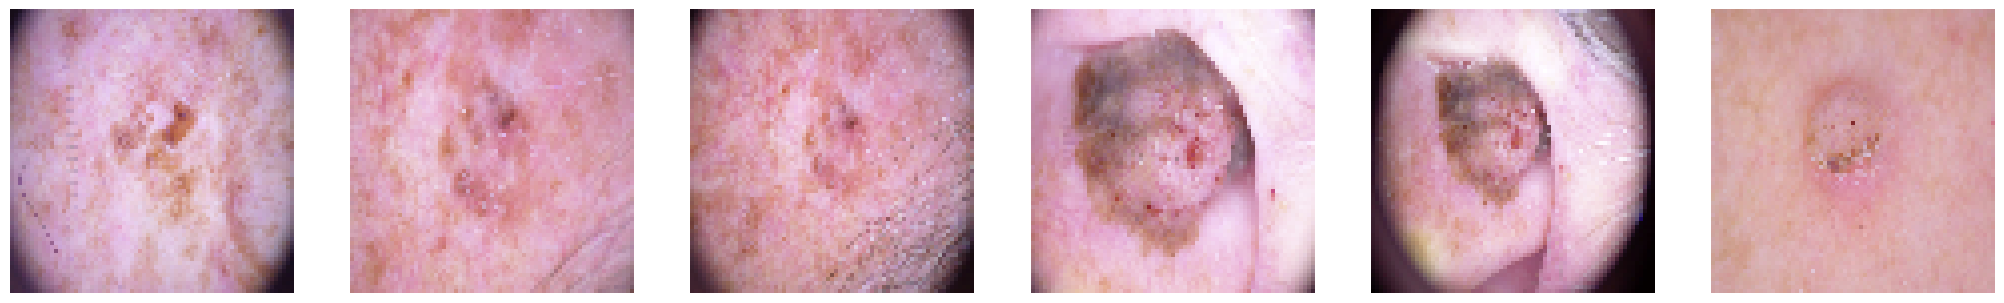

In [27]:
from numpy.core.function_base import linspace
#Visualizing the train data set 
plt.figure(figsize = (30, 15))
for i in range(1, 7, ):
    plt.subplot(1, 7, i)
    plt.imshow(x[i])
    #plt.title(lesion_names[np.argmax(y[i])])
    plt.axis("off")
plt.show()

### **Pre-Proccessing Stage**

In [28]:
# Splitting the data
#split the x and y into (x_train, x_test) and (y_train, y_test) respectively
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.10,random_state=28,stratify=y)

#split x_train and y_train into (x_train, x_val) and (y_train, y_val)
x_train,x_val,y_train,y_val =  train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train) 

In [29]:
#View the shape of the newly formed datasets
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(8111, 71, 71, 3)
(902, 71, 71, 3)
(1002, 71, 71, 3)
(8111,)
(902,)
(1002,)


In [30]:
y_idval = y_val

In [31]:
#Make a copy of the y_train array
y_id = y_train
y_id

array([2, 0, 1, ..., 1, 0, 0], dtype=int64)

In [32]:
# Make a copy of the y_test array
y_idtest = y_test
y_idtest

array([0, 0, 0, ..., 0, 3, 2], dtype=int64)

In [33]:
# One-Hot Encoding values
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes =7)
y_val = to_categorical(y_val , num_classes=7)

In [34]:
# print the shapes of the y variables
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(8111, 7)
(1002, 7)
(902, 7)


In [35]:
#Check for dataset Balanceness
df['lesion_ID'].value_counts()
#We can see that the dataset is not balanced

lesion_ID
0    6705
1    1113
2    1099
3     514
4     327
5     142
6     115
Name: count, dtype: int64

### **Resolving the Unbalanced data by weight assignment**


In [36]:
#from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

In [37]:
# Define the class labels and their corresponding weights
class_labels = np.unique(df['dx'])
y = df["dx"]
class_weights = class_weight.compute_class_weight('balanced', classes = class_labels, y = y)
class_weights

array([ 4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758,
        0.21338021, 10.07545272])

In [38]:
# Build a dictionary of the class_weight
class_weights = dict(zip([0,1,2,3,4,5,6], [4.37527304,  2.78349083,  1.30183284, 12.44099379,  1.28545758, 0.21338021, 10.07545272]))
class_weights


{0: 4.37527304,
 1: 2.78349083,
 2: 1.30183284,
 3: 12.44099379,
 4: 1.28545758,
 5: 0.21338021,
 6: 10.07545272}

#### **Using Xception Model**

In [39]:
# Defining base model using Xception module from Keras
from keras.applications import Xception

training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True 

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
filepath="bestmodel.keras"
# Add an early stopping
early_stop = EarlyStopping(monitor='val_accuracy',patience=6,mode='auto', restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor= np.sqrt(0.1), patience=4, verbose=1,cooldown=0,
                               mode='auto',min_delta=0.0001, min_lr=0.5e-6)

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
                             mode='auto', save_weights_only=False)

In [41]:
callbacks_list = [checkpoint, reduce_lr, early_stop]

In [42]:
#Adding layers at end
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Activation


n_classes = 7
model = base_model.output

model = Flatten()(model)

model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)

output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [43]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer= "adam", 
              metrics=['accuracy'])

In [44]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

In [45]:
# Declare the filepath for the saved model
filepath = "model_HAM10000_Xcept"

In [46]:
#Training our Model
historyXcept = model.fit(x_train,y_train, 
                    epochs=40, 
                    batch_size=90, 
                    #sample_weight=sample_weights,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks_list)

Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 0.9396 - accuracy: 0.6828
Epoch 1: val_accuracy improved from -inf to 0.38359, saving model to bestmodel.keras
91/91 [==============================] - 412s 4s/step - loss: 0.9396 - accuracy: 0.6828 - val_loss: 6.7111 - val_accuracy: 0.3836 - lr: 0.0010
Epoch 2/40
91/91 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.7963
Epoch 2: val_accuracy improved from 0.38359 to 0.76164, saving model to bestmodel.keras
91/91 [==============================] - 380s 4s/step - loss: 0.6017 - accuracy: 0.7963 - val_loss: 0.9530 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/40
91/91 [==============================] - ETA: 0s - loss: 0.4812 - accuracy: 0.8402
Epoch 3: val_accuracy did not improve from 0.76164
91/91 [==============================] - 371s 4s/step - loss: 0.4812 - accuracy: 0.8402 - val_loss: 1.1331 - val_accuracy: 0.7251 - lr: 0.0010
Epoch 4/40
91/91 [==============================] - ETA: 0s - los

In [47]:
pd.DataFrame(historyXcept.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,0.939569,0.682776,6.711115,0.383592,0.001000
1,0.601672,0.796326,0.953012,0.761641,0.001000
2,0.481175,0.840217,1.133118,0.725055,0.001000
3,0.335203,0.896067,0.931081,0.772727,0.001000
4,0.243309,0.923684,0.738395,0.786031,0.001000
5,0.182508,0.948958,0.941183,0.772727,0.001000
6,0.138031,0.959684,1.044878,0.759423,0.001000
7,0.149564,0.955986,0.795163,0.776053,0.001000
8,0.171335,0.949698,1.620525,0.702882,0.001000
9,0.058002,0.986192,0.653143,0.805987,0.000316


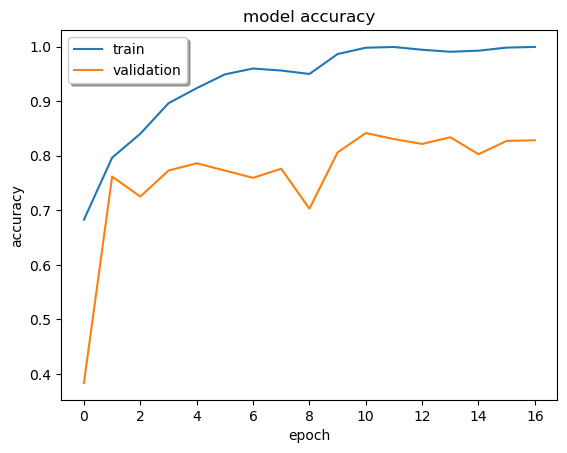

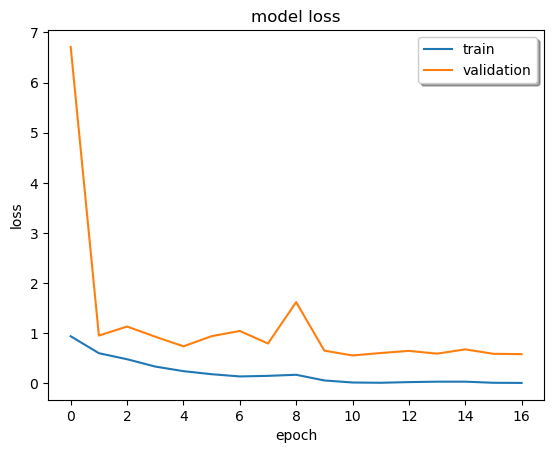

In [48]:
# summarize history for accuracy
plt.plot(historyXcept.history['accuracy'])
plt.plot(historyXcept.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left', shadow = True)
plt.show()
# summarize history for loss
plt.plot(historyXcept.history['loss'])
plt.plot(historyXcept.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best', shadow = True)
plt.show()

In [49]:
# Make predictions
predictions = model.predict_generator(x_test, verbose=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_17420\843022832.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(x_test, verbose=1)


32/32 [==============================] - 7s 188ms/step


In [50]:
predictions

array([[9.8830330e-01, 5.1563331e-03, 2.7713382e-03, ..., 8.8904379e-04,
        1.2728480e-03, 6.8893499e-04],
       [9.4621491e-01, 8.8087684e-03, 3.5906784e-02, ..., 1.8391355e-03,
        1.7654152e-03, 2.6314131e-03],
       [9.8940104e-01, 4.1376702e-03, 2.6232924e-03, ..., 8.4323302e-04,
        7.5465412e-04, 9.0257154e-04],
       ...,
       [9.8938143e-01, 3.7475065e-03, 2.4805698e-03, ..., 1.0992162e-03,
        1.0464969e-03, 8.3900749e-04],
       [8.2474597e-02, 2.2542892e-02, 6.6142470e-01, ..., 1.0896571e-02,
        3.4424358e-03, 2.6880635e-02],
       [1.6090000e-02, 2.6874259e-01, 6.8652731e-01, ..., 1.9116603e-02,
        1.5380986e-03, 2.0976993e-03]], dtype=float32)

In [51]:
# Convert predicted values from an array to a Dataframe and round up to 4 decimal place
# For each row there are predicted % for each of the classes 0 t0 6
pred = np.around(pd.DataFrame(predictions), 4)
pred

,0,1,2,3,4,5,6
0,0.9883,0.0052,0.0028,0.0009,0.0009,0.0013,0.0007
1,0.9462,0.0088,0.0359,0.0028,0.0018,0.0018,0.0026
2,0.9894,0.0041,0.0026,0.0013,0.0008,0.0008,0.0009
3,0.9853,0.0057,0.0036,0.0014,0.0013,0.0018,0.0010
4,0.9899,0.0038,0.0022,0.0014,0.0010,0.0010,0.0008
...,...,...,...,...,...,...,...
997,0.0035,0.9666,0.0219,0.0014,0.0056,0.0005,0.0005
998,0.9513,0.0136,0.0267,0.0027,0.0017,0.0021,0.0019
999,0.9894,0.0037,0.0025,0.0014,0.0011,0.0010,0.0008
1000,0.0825,0.0225,0.6614,0.1923,0.0109,0.0034,0.0269


In [52]:
# Obtain the indice of the maximum value for each row
y_pred = np.argmax(predictions, axis = 1)
y_pred

array([0, 0, 0, ..., 0, 2, 2], dtype=int64)

In [53]:
from sklearn.metrics import accuracy_score
import numpy as np


acc = accuracy_score(y_idtest, y_pred)

print("CNN Accuracy:", acc)

CNN Accuracy: 0.8622754491017964


In [63]:
train_acc = historyXcept.history['accuracy']
print(train_acc)

[0.6827764511108398, 0.7963259816169739, 0.8402169942855835, 0.8960670828819275, 0.9236838817596436, 0.9489582180976868, 0.9596843719482422, 0.9559857249259949, 0.9496979117393494, 0.9861915707588196, 0.9977807998657227, 0.9991369843482971, 0.9940820932388306, 0.9903834462165833, 0.9923560619354248, 0.9980273842811584, 0.9992602467536926]


In [64]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print("Train Accuracy:", train_acc)

254/254 [==============================] - 49s 192ms/step - loss: 0.0155 - accuracy: 0.9996
Train Accuracy: 0.9996301531791687


##### **Evaluating the Model**

In [54]:
# Create the confusion matrix 
confusion_matrix( y_idtest, y_pred)

array([[634,  15,  12,   4,   2,   4,   0],
       [ 20,  80,   9,   0,   2,   0,   0],
       [ 12,  17,  73,   3,   5,   0,   0],
       [  3,   4,   3,  34,   6,   0,   1],
       [  0,   1,   5,   2,  25,   0,   0],
       [  1,   1,   0,   0,   0,  12,   0],
       [  1,   1,   0,   2,   2,   0,   6]], dtype=int64)

In [55]:
# MAke a dataframe of the confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_pred, y_idtest), columns=lesion_names, index =lesion_names)

In [56]:
CMatrix

,Melanocytic nevi,Melanoma,Benign keratosis-like lesions,Basal cell carcinoma,Actinic keratoses,Vascular lesions,Dermatofibroma
Melanocytic nevi,634,20,12,3,0,1,1
Melanoma,15,80,17,4,1,1,1
Benign keratosis-like lesions,12,9,73,3,5,0,0
Basal cell carcinoma,4,0,3,34,2,0,2
Actinic keratoses,2,2,5,6,25,0,2
Vascular lesions,4,0,0,0,0,12,0
Dermatofibroma,0,0,0,1,0,0,6


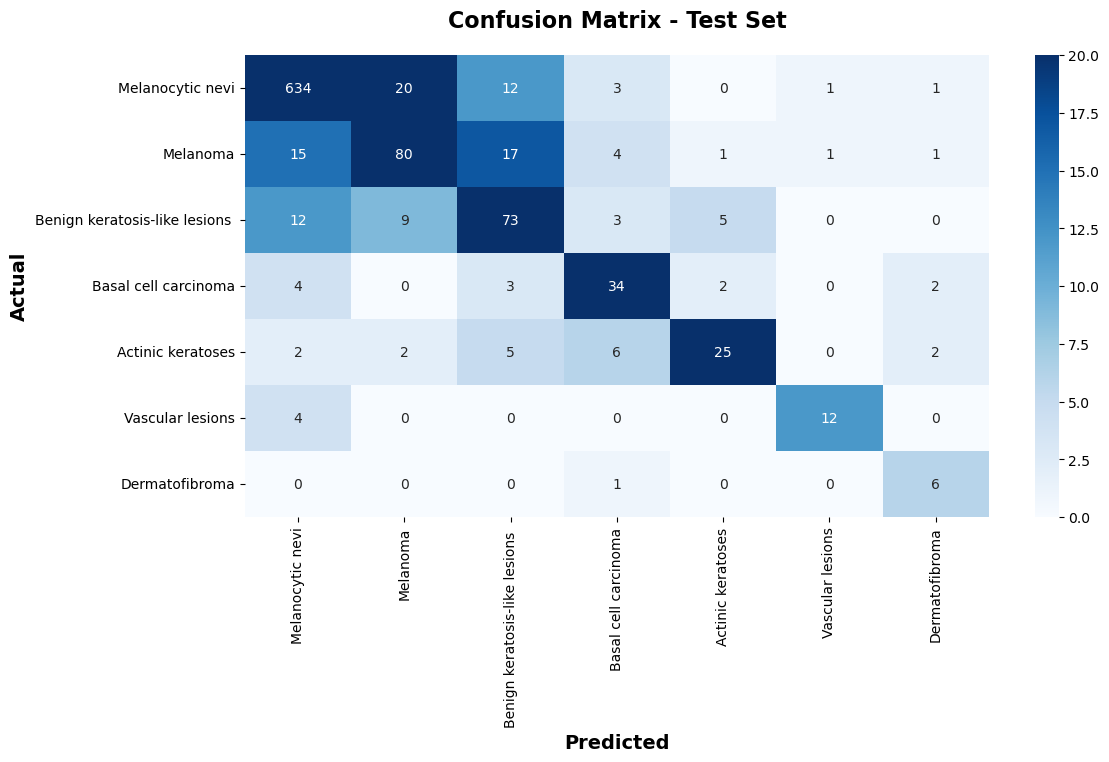

In [57]:
# View the heatmap of the confusion matrix
plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 20,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =90);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')    
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

In [67]:
model.save("xception_final.keras")

In [ ]:
np.save("y_pred.npy", y_pred)
np.save("y_true.npy", y_idtest)

In [59]:
# Show the accuracy of the model by class for each of the lesion in the dataset
class_accuracy = []

for i in range(7):
    acc_parz = round(np.mean(y_idtest[y_idtest == i] == y_pred[y_idtest == i]),2)
    lab_name = lesion_names[i]
    print('The Model accuracy for ',lab_name,'=',acc_parz)
    class_accuracy.append(acc_parz)

The Model accuracy for  Melanocytic nevi = 0.94
The Model accuracy for  Melanoma = 0.72
The Model accuracy for  Benign keratosis-like lesions  = 0.66
The Model accuracy for  Basal cell carcinoma = 0.67
The Model accuracy for  Actinic keratoses = 0.76
The Model accuracy for  Vascular lesions = 0.86
The Model accuracy for  Dermatofibroma = 0.5


In [60]:
# Get the tabulated visualization of the Model's accuracy for each lesion 
acc_tab = pd.DataFrame(list(zip(lesion_ID_dict, class_accuracy)))
acc_tab.columns = ["Lesion", "Accuracy"]
acc_tab

,Lesion,Accuracy
0,nv,0.94
1,mel,0.72
2,bkl,0.66
3,bcc,0.67
4,akiec,0.76
5,vasc,0.86
6,df,0.50


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_idtest,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       671
           1       0.67      0.72      0.70       111
           2       0.72      0.66      0.69       110
           3       0.76      0.67      0.71        51
           4       0.60      0.76      0.67        33
           5       0.75      0.86      0.80        14
           6       0.86      0.50      0.63        12

    accuracy                           0.86      1002
   macro avg       0.76      0.73      0.73      1002
weighted avg       0.86      0.86      0.86      1002



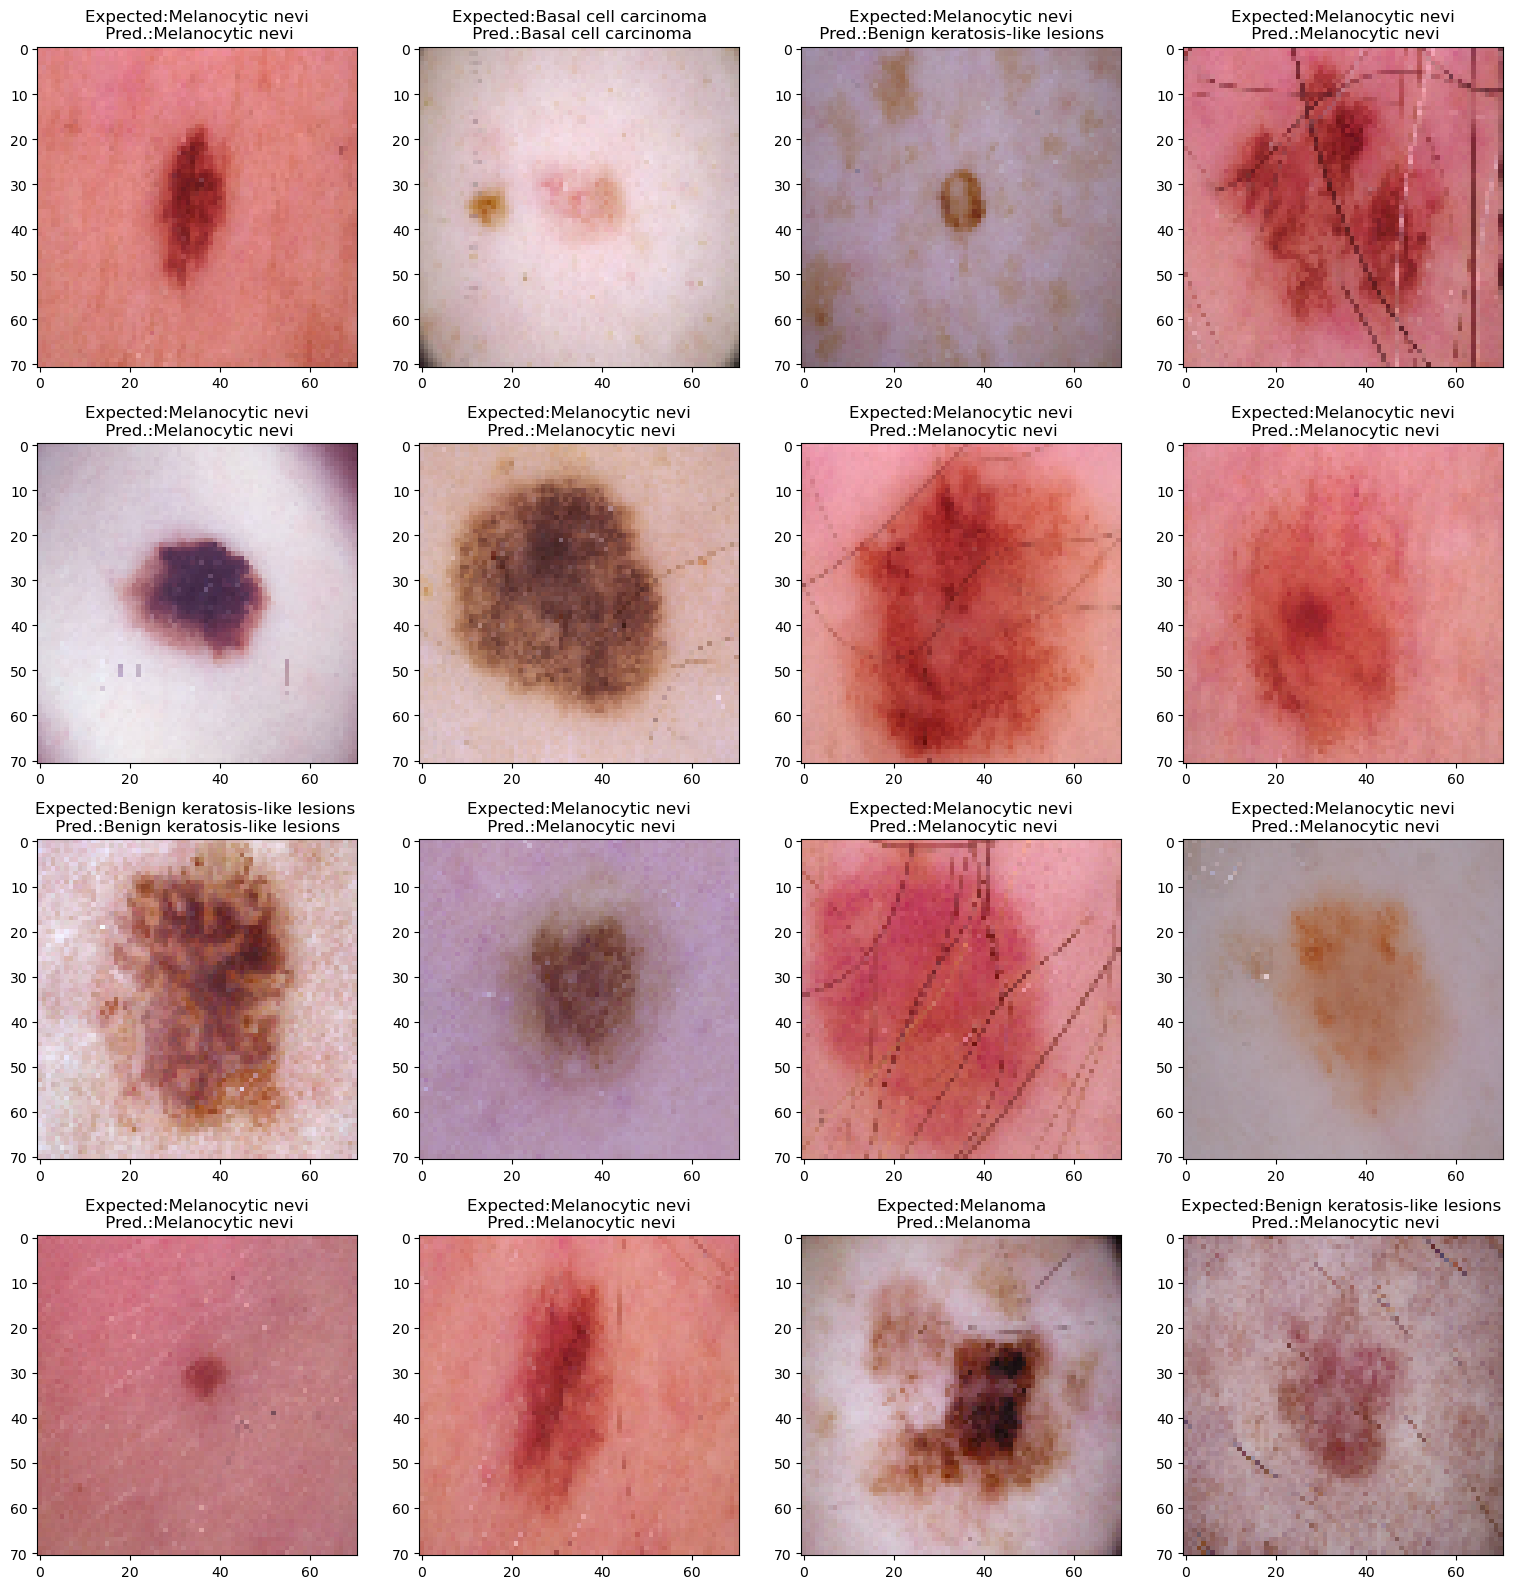

In [62]:
# Show the Image plot along side the Label for Expected and Predicted lesion. 
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(x_test[index])
    label_exp = lesion_names[y_idtest[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    #label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred))  
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('final_figure.png',dpi=300)
plt.show()